# Prever Evasão dos Alunos

Identificar o potencial de egressp de um determinado aluno permite à Associação Passos Mágicos criar planos preventivos, tanto para o suporte do aluno quanto à manutenção de sua estrutura.

# Imports

In [138]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [139]:
# Pré-processamento
from imblearn.over_sampling import RandomOverSampler # Balanceamento de classes

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Avaliação do modelo de classificação binária
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Salvar modelo
import pickle

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

# Otimização de hiperparâmetros
import keras_tuner

# Versão do TensorFlow
print(tf.__version__)

2.17.0


In [140]:
from utils import *

In [141]:
seed = 19

# Pré-processamento dos Dados

In [142]:
df = pd.read_csv('data\cleaned\df_all.csv')

df

,nome,instituicao_ensino_aluno,idade_aluno,anos_pm,ponto_virada,inde,inde_conceito,pedra,destaque_ieg,destaque_ida,destaque_ipv,iaa,ieg,ips,ida,ipp,ipv,ian,ano,fase,turma,sinalizador_ingressante,rec_equipe_1,rec_equipe_2,rec_equipe_3,rec_equipe_4,nivel_ideal,defasagem,ano_ingresso,bolsista,cg,cf,ct,nota_port,nota_mat,nota_ing,qtd_aval,rec_ava_1,rec_ava_2,rec_ava_3,rec_ava_4,indicado_bolsa,grupo_fase,saiu,atencao,destaque
0,ALUNO-1,Escola Pública,11.0,2.0,False,7.883752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.50002,8.700000,7.500,7.000000,5.93750,7.750000,10.0,2020,2,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
1,ALUNO-3,Escola Pública,12.0,2.0,False,7.856390,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.91667,8.900000,7.500,5.500000,8.12500,8.111113,10.0,2020,3,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
2,ALUNO-4,Escola Pública,10.0,2.0,False,5.076252,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.00002,4.100000,6.875,0.000000,7.18750,7.750000,5.0,2020,1,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,True,False,False
3,ALUNO-5,Escola Pública,10.0,1.0,False,8.077085,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integração aos...,7.50002,8.000000,7.500,7.500000,8.43750,8.166665,10.0,2020,2,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
4,ALUNO-8,Rede Decisão/União,14.0,3.0,True,8.381391,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.33334,9.900000,4.375,7.333333,8.75000,8.944450,10.0,2020,4,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,ALUNO-1342,NaN,NaN,NaN,False,8.150001,NaN,Topázio,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,7.91668,9.666667,7.500,7.750000,6.25000,7.500000,10.0,2022,2,K,NaN,NaN,NaN,NaN,NaN,Fase 2 (5º e 6º ano),NaN,2022.0,False,99.0,13.0,1.0,6.000000,9.500000,NaN,3.0,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,False,Fases 1-7,False,False,False
2271,ALUNO-1343,NaN,NaN,NaN,False,5.674644,NaN,Quartzo,Melhorar: Melhorar a sua entrega de lições de ...,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,7.41668,6.470435,6.250,2.000000,6.25000,7.444443,5.0,2022,2,K,NaN,NaN,NaN,NaN,NaN,Fase 4 (9º ano),NaN,2018.0,False,763.0,141.0,11.0,2.000000,2.000000,NaN,3.0,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,False,Fases 1-7,False,False,False
2272,ALUNO-1346,NaN,NaN,NaN,True,8.135538,NaN,Topázio,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,9.00002,9.031839,7.500,9.000000,5.62500,9.083340,5.0,2022,0,U,NaN,NaN,NaN,NaN,NaN,Fase 1 (4º ano),NaN,2022.0,False,105.0,30.0,2.0,9.166667,8.833333,NaN,2.0,Promovido de Fase,Promovido de Fase,NaN,NaN,False,Fases 1-7,False,False,False
2273,ALUNO-1348,NaN,NaN,NaN,False,6.749981,NaN,Ágata,Destaque: A sua boa entrega das lições de cas

In [143]:
# Quase 22% dos alunos saíram
df.saiu.value_counts()

saiu
False    1776
True      499
Name: count, dtype: int64

In [144]:
# 24 alunos saíram e estavam na última fase
df.groupby('grupo_fase').saiu.size()

grupo_fase
Fase 8         24
Fases 1-7    2251
Name: saiu, dtype: int64

Remover alunos da última fase, já que é esperado que os alunos deixem o programa educacional:

In [145]:
df = df[df['fase'] != 8]

# A diferença é de 24 alunos
df.saiu.value_counts()

saiu
False    1776
True      475
Name: count, dtype: int64

A função `identify_saiu()` adiciona a coluna `saiu`, com preenchimento de `True` para alunos que saíram do curso e `False` para os que continuaram. No entanto, ela não consegue identificar quem saiu no último ano, uma vez que compara os estudantes entre o ano anterior e o atual. Por isso, os dados de 2022 serão removidos do treinamento do modelo.

In [146]:
df_2022 = df.query('ano == 2022').copy()

df = df.query('ano < 2022').copy()

df.shape[0], df_2022.shape[0]

(1389, 862)

Entre os anos de 2020 e 2021, proximadamente 34% dos alunos saíram antes de completar a última fase:

In [147]:
df.saiu.value_counts(normalize=True)*100

saiu
False    65.802736
True     34.197264
Name: proportion, dtype: float64

Aproximadamente 35% dos alunos (248) saíram em 2020, enquanto 33% (227) saíram em 2021:

In [148]:
df.groupby('ano').saiu.value_counts(normalize=True)*100

ano   saiu 
2020  False    65.007112
      True     34.992888
2021  False    66.618076
      True     33.381924
Name: proportion, dtype: float64

Separação das features e variável alvo:

In [149]:
# Coluna a ser prevista - saiu da PM
y_col = 'saiu'

# Features - colunas importantes e sempre presentes nos datasets analisados
X_cols = ['fase', 'turma', 'ponto_virada', 'ano', 'bolsista', 'iaa', 'ida', 'ian', 'ieg', 'ips', 'ipp', 'ipv', 'atencao', 'destaque']

X = df[X_cols].copy()
y = df[y_col].copy()

# Verificando valores nulos
X.isna().sum().sum(), y.isna().sum()

(0, 0)

A variável INDE é resultante da soma ponderada dos demais indicadores e, para evitar a multicolinearidade, não foi adicionada como feature do modelo.

In [150]:
# Verificando os tipos
X.dtypes

fase              int64
turma            object
ponto_virada       bool
ano               int64
bolsista           bool
iaa             float64
ida             float64
ian             float64
ieg             float64
ips             float64
ipp             float64
ipv             float64
atencao            bool
destaque           bool
dtype: object

In [151]:
# Ano e Fase são variáveis categóricos
X['ano'] = X['ano'].astype('object')
X['fase'] = X['fase'].astype('object')

In [152]:
# Separando as variáveis categóricas, booleanas e numéricas
cat_vars = X.select_dtypes(include=['object']).columns
bool_vars = X.select_dtypes(include=['bool']).columns
num_vars = X.select_dtypes(include=['int64', 'float64']).columns

cat_vars, bool_vars, num_vars

(Index(['fase', 'turma', 'ano'], dtype='object'),
 Index(['ponto_virada', 'bolsista', 'atencao', 'destaque'], dtype='object'),
 Index(['iaa', 'ida', 'ian', 'ieg', 'ips', 'ipp', 'ipv'], dtype='object'))

In [153]:
# Variáveis booleanas para numéricas
X[bool_vars] = X[bool_vars].astype(int)

A proporção entre alunos que saíram ou não é desbalanceada e, portanto, realiza-se o *oversampling* da classe minoritária.  Um próximo passo do projeto é adicionar dados de outros anos e realizar o *undersampling* da classe majoritária - melhor prática, inclusive para evitar *overfitting*. Isso também permitirá identificar padrões de evasão que se repetem ao longo do tempo.

In [154]:
# Inicializar o RandomOverSampler
ros = RandomOverSampler(random_state=seed)

# Aplicar o oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# verificando o balanceamento
y_resampled.value_counts(normalize=True)*100

saiu
False    50.0
True     50.0
Name: proportion, dtype: float64

A separação do dataset em treino, teste e validação é feita de forma estratificada pela coluna "ano", para que haja igual distribuição de alunos em cada conjunto. Por isso, a transformação de dados categóricos em numéricos é feita após a separação dos dados.

In [155]:
strat = 'ano'

# Divisão em treino e teste  - mesma quantidade de alunos por ano
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=X[strat])

# Divisão de dados em Validação - 0.25*0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed, stratify=X_train[strat])

print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('X_test:', X_test.shape)

X_train: (833, 14)
X_val: (278, 14)
X_test: (278, 14)


In [156]:
# Normalização - MinMax porque todos os números são positivos
scaler = MinMaxScaler()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_val[num_vars] = scaler.transform(X_val[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train.describe()

,ponto_virada,bolsista,iaa,ida,ian,ieg,ips,ipp,ipv,atencao,destaque
count,833.000000,833.0,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000,833.000000
mean,0.151261,1.0,0.830127,0.581206,0.620648,0.727947,0.680813,0.746572,0.748969,0.080432,0.013205
std,0.358518,0.0,0.192917,0.264485,0.337538,0.243560,0.141525,0.129759,0.137710,0.272124,0.114222
min,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.0,0.800000,0.433333,0.333333,0.580000,0.630000,0.720000,0.688889,0.000000,0.000000
50%,0.000000,1.0,0.880000,0.620000,0.333333,0.800000,0.750000,0.770000,0.766667,0.000000,0.000000
75%,0.000000,1.0,0.920000,0.766667,1.000000,0.920000,0.750000,0.810000,0.830000,0.000000,0.000000
max,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [157]:
# Verificar todas as turmas
turmas = X_train.turma.unique().tolist()

In [158]:
# Coluna Ano e Fase para One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=['ano', 'fase', 'turma'])
X_test = pd.get_dummies(X_test, columns=['ano', 'fase', 'turma'])
X_val = pd.get_dummies(X_val, columns=['ano', 'fase', 'turma'])
                       
X_train.shape, X_test.shape, X_val.shape

((833, 42), (278, 42), (278, 40))

In [159]:
# Se alguma turma não estiver presente em X_test ou X_val, adicionar a coluna com valores 0
for turma in turmas:
    if 'turma_' + turma not in X_test.columns:
        X_test['turma_' + turma] = 0
    if 'turma_' + turma not in X_val.columns:
        X_val['turma_' + turma] = 0

X_train.shape, X_test.shape, X_val.shape

((833, 42), (278, 42), (278, 42))

In [160]:
# Concatenar dados de treino e validação para retreinar o modelo
X_all = pd.concat([X_train, X_val])
y_all = pd.concat([y_train, y_val])

# Transformar em DataFrame para gerar previsões
X_all_df = pd.DataFrame(X_all, columns=X_train.columns)

X_all.shape, y_all.shape

((1111, 42), (1111,))

In [161]:
# Garantir que X e y são arrays numpy e do tipo float32
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.float32)

# Modelo Baseline

O modelo baseline será uma rede neural simples, com 2 camadas ocultas com ativação ReLU (64 e 32 neurônios, respectivamente). A previsão será de uma classe binária (saiu/não saiu), então a camada de saída terá apenas um neurônio com função de ativação sigmoidal. A função de perda será a entropia cruzada binária e a métrica de avaliação será a acurácia.

In [26]:
# Criar modelo base simples
base_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilação
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Treinamento
base_history = base_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6025 - loss: 0.6663 - precision: 0.4508 - recall: 0.3613 - val_accuracy: 0.6727 - val_loss: 0.6119 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6569 - loss: 0.6226 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6727 - val_loss: 0.6048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6735 - loss: 0.5887 - precision: 0.6071 - recall: 0.0069 - val_accuracy: 0.6978 - val_loss: 0.5964 - val_precision: 1.0000 - val_recall: 0.0769
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6755 - loss: 0.5966 - precision: 0.8001 - recall: 0.0728 - val_accuracy: 0.7014 - val_loss: 0.5894 - val_precision: 0.9000 - val_recall: 0.0989
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7006 - loss: 0.5805 - precision: 0.7122 - recall: 0.1839 - val_accuracy: 0.7050 

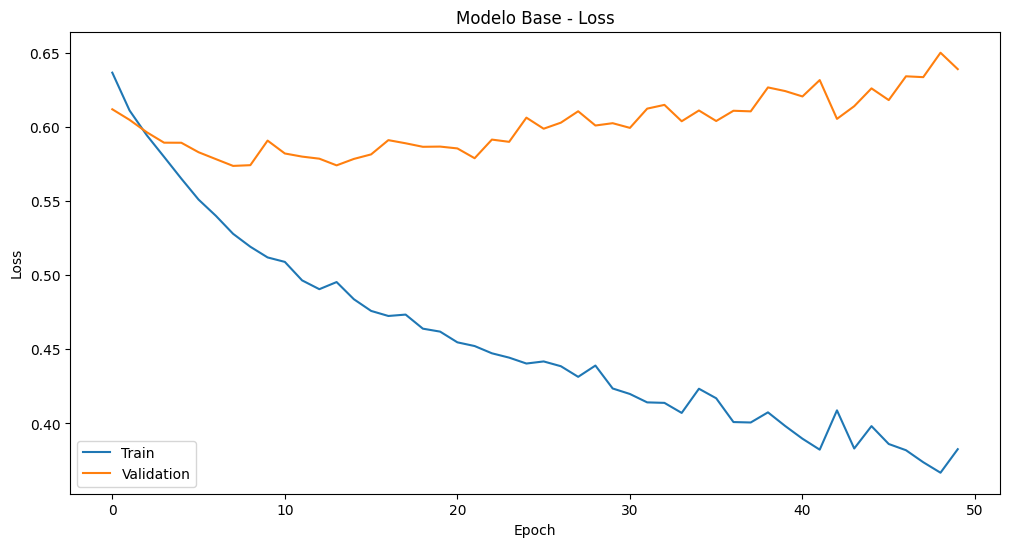

In [27]:
# Plotar função de custo
plt.figure(figsize=(12, 6))
plt.plot(base_history.history['loss'], label='Train')
plt.plot(base_history.history['val_loss'], label='Validation')
plt.title('Modelo Base - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

O modelo está melhorando nos dados de treino e piorando nos dados de validação, o que descreve o *overfitting*. Então, uma arquitetura de modelo mais simples e menor número de épocas será testada.

In [28]:
base_model_2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilação
base_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Treinamento
base_history_2 = base_model_2.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3042 - loss: 0.8336 - precision: 0.2986 - recall: 0.9747 - val_accuracy: 0.4137 - val_loss: 0.7111 - val_precision: 0.2857 - val_recall: 0.5275
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5256 - loss: 0.6866 - precision: 0.2913 - recall: 0.2895 - val_accuracy: 0.6727 - val_loss: 0.6530 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6960 - loss: 0.6279 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6727 - val_loss: 0.6381 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6697 - loss: 0.6201 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6727 - val_loss: 0.6373 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6467 - loss: 0.6311 - precision: 0.0000e+00 - recall: 0.0000e+00 - va

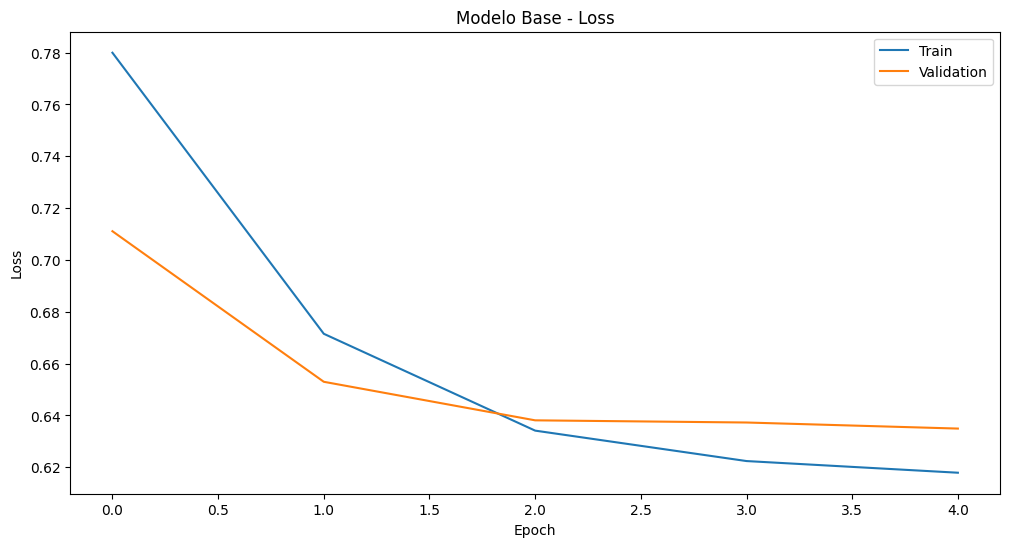

In [29]:
# Plotar função de custo
plt.figure(figsize=(12, 6))
plt.plot(base_history_2.history['loss'], label='Train')
plt.plot(base_history_2.history['val_loss'], label='Validation')
plt.title('Modelo Base - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Avaliação do modelo
base_model.evaluate(X_test, y_test)

# Previsto
y_pred_base = base_model.predict(X_test)

# Ajustar para 0 ou 1
y_pred_base = np.round(y_pred_base)

# Matriz de confusão
cm_base = confusion_matrix(y_test, y_pred_base)

# Relatório de classificação
print(classification_report(y_test, y_pred_base))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.6807 - loss: 0.7006 - precision: 0.5489 - recall: 0.4559
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

       False       0.70      0.78      0.74       172
        True       0.56      0.45      0.50       106

    accuracy                           0.65       278
   macro avg       0.63      0.62      0.62       278
weighted avg       0.64      0.65      0.65       278



O modelo baseline obteve acurácia de 67% nos dados de teste.

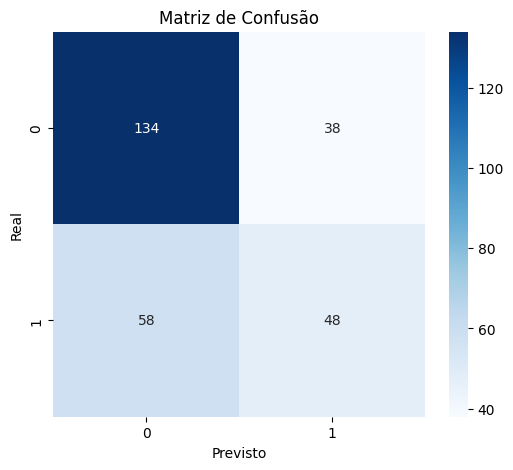

In [31]:
# Plotar heatmap da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

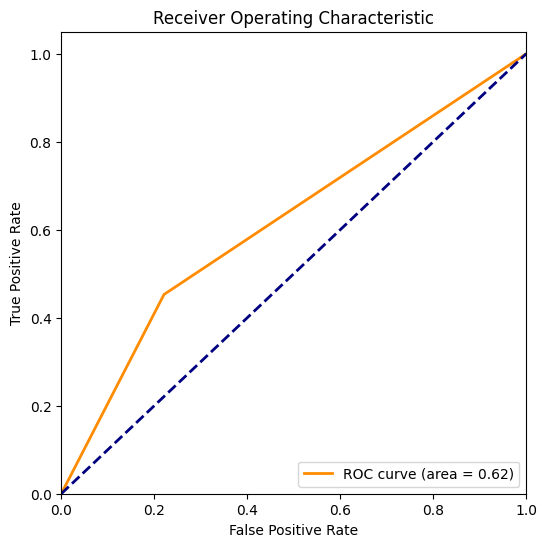

In [32]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Otimização de Hiperparâmetros

In [33]:
import keras
from keras import layers
from keras import regularizers
import keras_tuner

# Modelo de regressão com hiperparâmetros ajustáveis
class HyperClassificationModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        for i in range(hp.Int("num_layers", 1, 5)):
            # Adiciona de 1 a 5 camadas densas
            model.add(
                layers.Dense(
                    # 16 a 512 neurônios, aumentando de 16 em 16
                    units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=16),
                    # 2 funções de ativação - ReLU e Tanh
                    activation=hp.Choice("activation", ["relu", "tanh"])
                )
            )
            # Testa diferentes taxas de dropout (prevenção de overfitting)
            model.add(layers.Dropout(hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)))
        # Camada de saída
        model.add(layers.Dense(1, activation="sigmoid"))
        # Taxa de aprendizado de 0.0001 a 0.01
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        
        # Compilação do modelo
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss="binary_crossentropy",
            metrics=["accuracy", "Precision", "Recall"],
        )
        
        return model

    def fit(self, hp, model, x, y, **kwargs):
        # Número de épocas e tamanho do batch
        epochs = hp.Choice("epochs", values=[50, 100, 500])
        batch_size = hp.Choice("batch_size", values=[32, 64, 128])
        
        # Testando com e sem embaralhamento dos dados
        shuffle = hp.Boolean("shuffle")
        
        return model.fit(
            x,
            y,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=shuffle,
            **kwargs,
        )

In [34]:
# Random Search
tuner = keras_tuner.RandomSearch(
    hypermodel=HyperClassificationModel(),
    objective="val_accuracy", # Métrica a ser otimizada -> Acurácia
    max_trials=5,
    executions_per_trial=5,
    overwrite=True,
    seed=seed,
    directory="models",
    project_name="student_dropout",
)

# Busca de hiperparâmetros
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

Trial 5 Complete [00h 02m 01s]
val_accuracy: 0.7417266130447387

Best val_accuracy So Far: 0.7417266130447387
Total elapsed time: 00h 04m 03s


In [35]:
# Melhores hiperparâmetros
hypermodel = HyperClassificationModel(),
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

# Arquitetura do modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 48)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 0 (0.00 B)

In [196]:
best_hp.values

{'num_layers': 1,
 'units_0': 48,
 'activation': 'tanh',
 'dropout_rate_0': 0.4,
 'lr': 0.006599917029213527,
 'units_1': 176,
 'dropout_rate_1': 0.1,
 'units_2': 144,
 'dropout_rate_2': 0.5,
 'units_3': 240,
 'dropout_rate_3': 0.2,
 'epochs': 500,
 'batch_size': 128,
 'shuffle': False,
 'units_4': 144,
 'dropout_rate_4': 0.30000000000000004}

In [36]:
# Retreinar o melhor modelo com todos os dados de treino e validação
history = model.fit(X_all, y_all, epochs=50)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step - Precision: 0.4315 - Recall: 0.1665 - accuracy: 0.6212 - loss: 0.6861 
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - Precision: 0.6128 - Recall: 0.2675 - accuracy: 0.6779 - loss: 0.5941
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - Precision: 0.6321 - Recall: 0.2432 - accuracy: 0.6998 - loss: 0.5813       
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - Precision: 0.6793 - Recall: 0.3314 - accuracy: 0.7313 - loss: 0.5457       
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - Precision: 0.6532 - Recall: 0.3957 - accuracy: 0.7239 - loss: 0.5481
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - Precision: 0.6754 - Recall: 0.4264 - accuracy: 0.7425 - loss: 0.5295
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - Precision: 0.6578 - Recall: 0.3630 - accuracy: 0.7070 - loss: 0.5744
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - Precision: 0.6917 - Recall: 0.3693 - accuracy: 0.7386 - loss: 0.5409
E

In [37]:
# Prever com modelo obtido com RandomSearch
y_pred = model.predict(X_test)

# Ajustar para 0 ou 1
y_pred = np.round(y_pred)

# Avaliação do modelo
model.evaluate(X_test, y_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Relatório de classificação
print(classification_report(y_test, y_pred))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - Precision: 0.6085 - Recall: 0.4552 - accuracy: 0.7066 - loss: 0.5503
              precision    recall  f1-score   support

       False       0.71      0.84      0.77       172
        True       0.63      0.44      0.52       106

    accuracy                           0.69       278
   macro avg       0.67      0.64      0.64       278
weighted avg       0.68      0.69      0.67       278



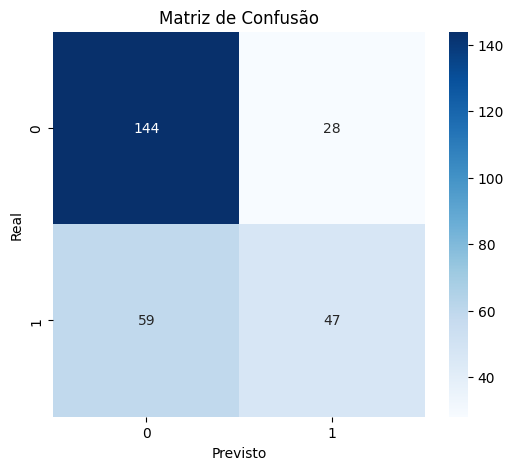

In [38]:
# Plotar heatmap da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

A acurária melhorou para 69%. Melhorar ainda mais dependerá de maior quantidade de dados sobre outros anos. Existem apenas os anos de 2020 e 2021 no treinamento, sendo que 2020 foi atípico por conta da pandemia de COVID-19.

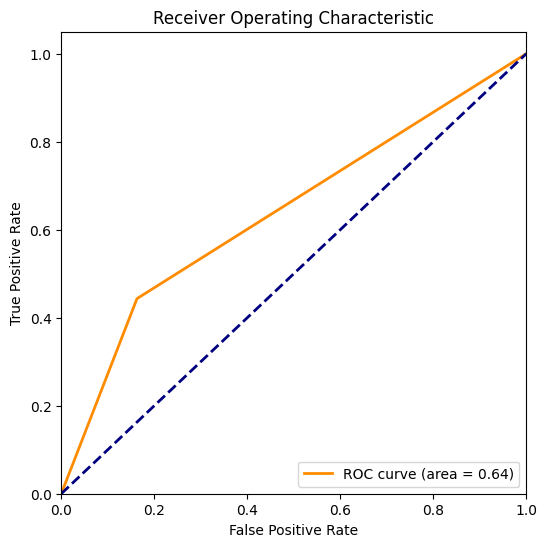

In [39]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Salvar o melhor modelo encontrado pela Random Search:

In [40]:
# Com Keras
model.save('models/students_dropout_classification_model.h5') # H5 é o formato legado, mas ainda precisa ser atualizado em algumas bibliotecas
model.save('models/students_dropout_classification_model.keras') # Keras é o formato atual

# Com Pickle
with open('models/students_dropout_classification_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Análise do Melhor Modelo

In [123]:
preds_df = X_all_df.copy()

# Reverter a normalização
preds_df[num_vars] = scaler.inverse_transform(preds_df[num_vars])

# Desfazer One-Hot Encoding de Ano, Fase e Turma
preds_df['ano'] = preds_df.filter(like='ano').idxmax(axis=1).str.replace('ano_', '').astype(int)
preds_df['fase'] = preds_df.filter(like='fase').idxmax(axis=1).str.replace('fase_', '').astype(int)
preds_df['turma'] = preds_df.filter(like='turma').idxmax(axis=1).str.replace('turma_', '')

# Calcular o INDE e a pedra do aluno para análise
preds_df = calculate_inde(preds_df)

# Adicionar pedra
preds_df = fill_pedra(preds_df)

# Adicionar saiu_real
preds_df['saiu_real'] = y_all.astype(int)

# Adicionar as previsões
preds_df['saiu_pred'] = model.predict(X_all).round().astype(int)

# Adicionar as probabilidades
preds_df['prob_pred'] = model.predict(X_all)

# Errados
preds_df[preds_df['saiu_real'] != preds_df['saiu_pred']].sort_values('prob_pred', ascending=False)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


,ponto_virada,bolsista,iaa,ida,ian,ieg,ips,ipp,ipv,atencao,destaque,ano_2020,ano_2021,fase_0,fase_1,fase_2,fase_3,fase_4,fase_5,fase_6,fase_7,turma_A,turma_B,turma_C,turma_D,turma_E,turma_F,turma_G,turma_H,turma_I,turma_J,turma_K,turma_L,turma_M,turma_N,turma_O,turma_P,turma_Q,turma_R,turma_S,turma_T,turma_X,ano,fase,turma,inde,pedra,saiu_real,saiu_pred,prob_pred
387,0,1,6.25001,4.666667,10.0,7.6,5.625,7.03125,7.750000,0,0,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,0,2020,7,B,6.893959,Ágata,0,1,0.962455
504,0,1,9.58335,1.333333,5.0,0.8,3.125,7.81250,6.749995,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,False,False,False,False,False,0,2020,5,G,4.328751,Quartzo,0,1,0.897845
16,0,1,8.75001,5.000000,5.0,6.1,6.250,7.65625,8.291670,1,0,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,0,2020,7,B,6.643960,Ágata,0,1,0.895213
93,0,1,7.91667,2.833333,5.0,0.9,3.125,5.62500,4.125002,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,False,False,False,False,False,0,2020,5,G,3.738334,Quartzo,0,1,0.892668
443,0,1,7.50000,3.000000,5.0,1.9,7.500,7.18750,6.833330,0,0,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0,False,False,False,False,False,0,2020,5,F,5.065416,Quartzo,0,1,0.877157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,0,1,8.50000,7.100000,10.0,7.1,7.500,8.30000,7.600000,0,0,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,False,False,False,False,False,0,2021,2,N,7.790000,Ametista,1,0,0.121767
692,0,1,7.91668,8.500000,10.0,8.8,2.500,2.50000,2.750000,1,0,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,0,2020,0,A,6.301668,Ágata,1,0,0.121028
1060,1,1,8.00000,7.300000,5.0,9.6,7.500,8.10000,9.100000,0,0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0,False,False,False,False,False,0,2021,1,N,8.060000,Ametista,1,0,0.114961
1111,1,1,9.50000,8.900000,10.0,10.0,7.500,8.10000,9.600000,0,0,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,0,2021,2,A,9.210000,Topázio,1,0,0.110621


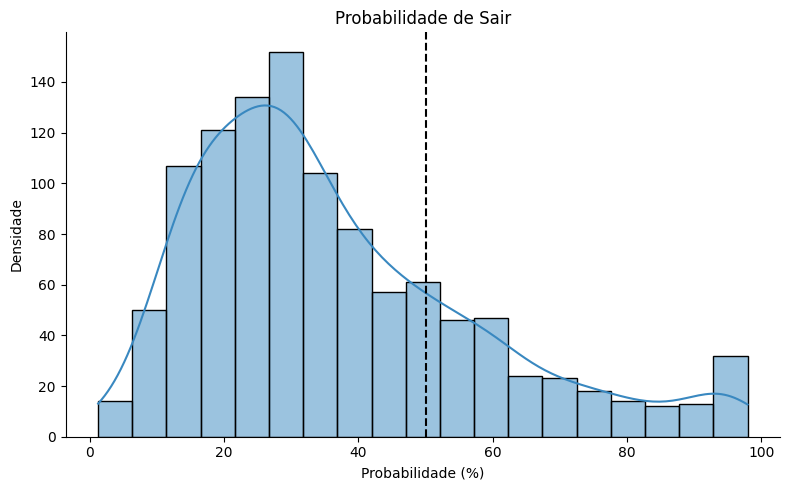

In [181]:
# Plotar a probabilidade de sair
plt.figure(figsize=(8, 5))
sns.histplot(preds_df['prob_pred'] * 100, kde=True, color='#3988c0')
# linha em 50% (limite)
plt.axvline(50, color='black', linestyle='--')
plt.title('Probabilidade de Sair')
plt.xlabel('Probabilidade (%)')
plt.ylabel('Densidade')
sns.despine()
plt.tight_layout()
plt.show()

In [125]:
df.groupby('fase').saiu.value_counts()

fase  saiu 
0     False    146
      True      58
1     False    217
      True      91
2     False    223
      True      94
3     False    165
      True      72
4     False     75
      True      39
5     False     57
      True      47
6     False     29
      True      24
7     True      50
      False      2
Name: count, dtype: int64

Existem apenas 2 alunos que saíram na fase 7 e, portanto, o modelo não consegue prever bem a evasão nessa fase. As fases 4 e 5 também têm baixa representatividade de alunos que saíram e podem ser melhoradas com mais dados.

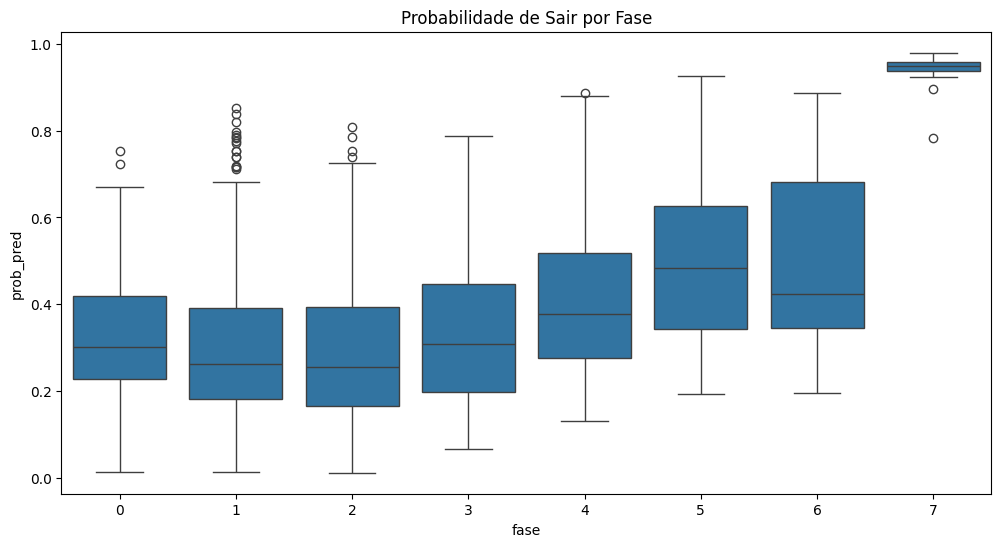

In [126]:
# probabilidade de sair por fase
plt.figure(figsize=(12, 6))
sns.boxplot(data=preds_df, x='fase', y='prob_pred')
plt.title('Probabilidade de Sair por Fase')
plt.show()

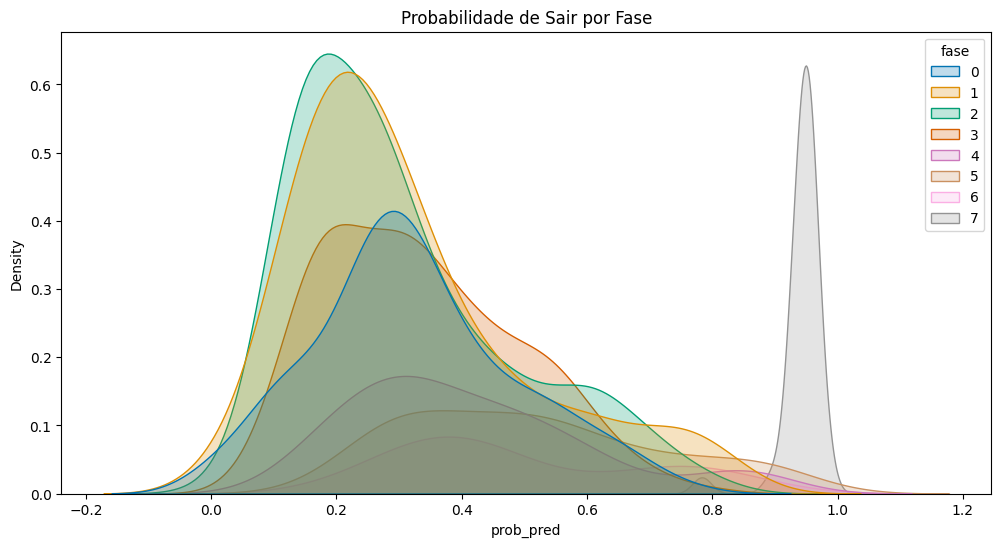

In [127]:
# KDE plot probabilidade de sair por fase
plt.figure(figsize=(12, 6))
sns.kdeplot(data=preds_df, x='prob_pred', hue='fase', fill=True, palette='colorblind')
plt.title('Probabilidade de Sair por Fase')
plt.show()

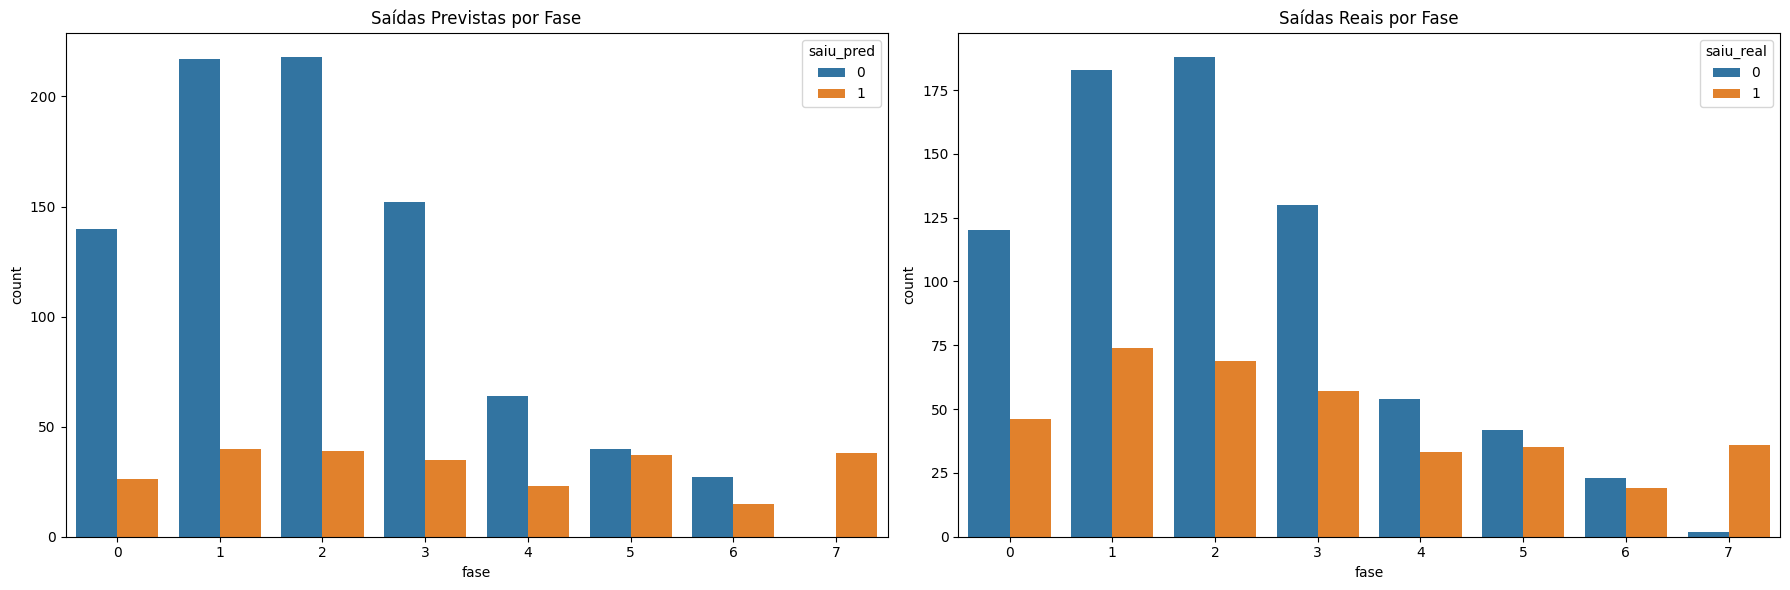

In [128]:
# Saídas por fase previstas x real
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot(data=preds_df, x='fase', hue='saiu_pred', ax=axs[0])
sns.countplot(data=preds_df, x='fase', hue='saiu_real', ax=axs[1])
axs[0].set_title('Saídas Previstas por Fase')
axs[1].set_title('Saídas Reais por Fase')
plt.tight_layout()
plt.show()

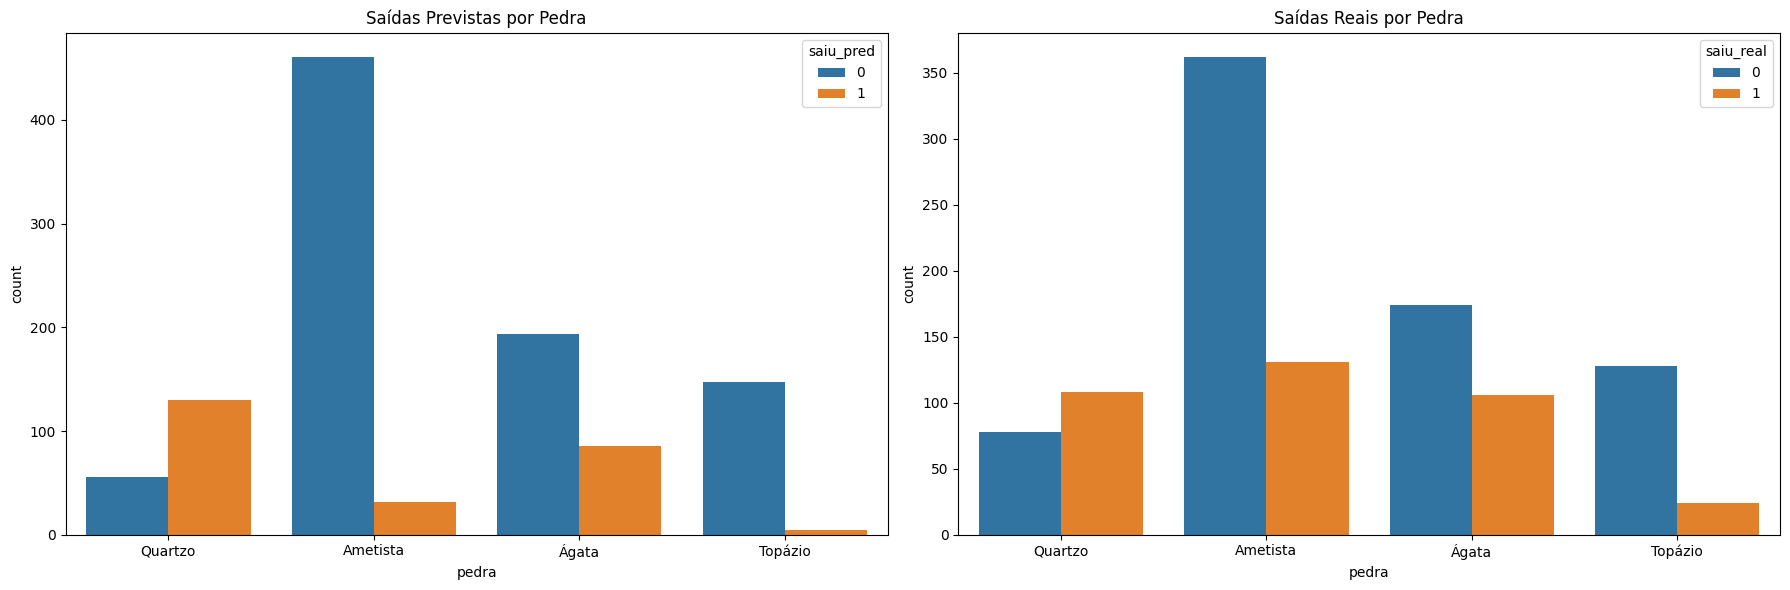

In [129]:
# Plotar quantos saíram por pedra
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot(data=preds_df, x='pedra', hue='saiu_pred', ax=axs[0])
sns.countplot(data=preds_df, x='pedra', hue='saiu_real', ax=axs[1])
axs[0].set_title('Saídas Previstas por Pedra')
axs[1].set_title('Saídas Reais por Pedra')
plt.tight_layout()
plt.show()

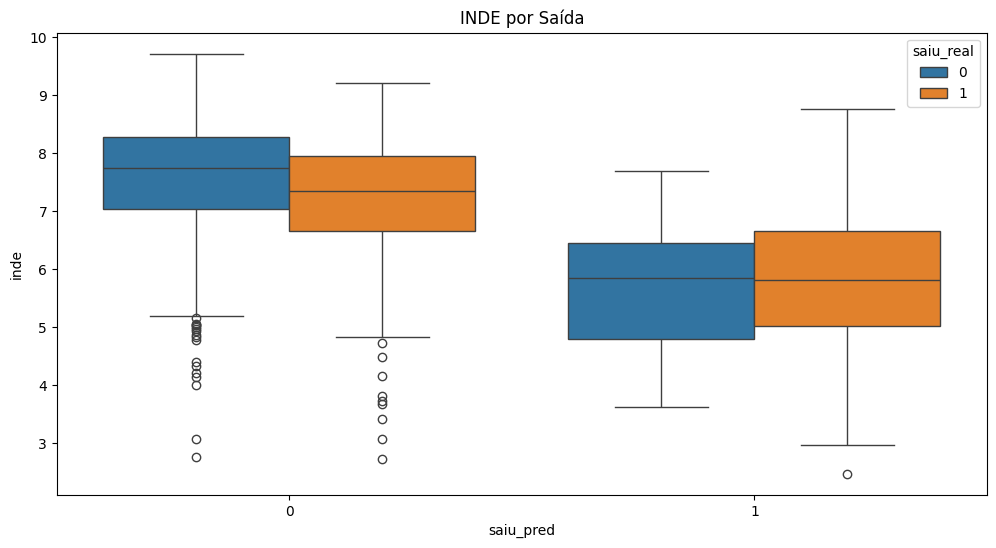

In [130]:
# Boxplot de INDE por saída
plt.figure(figsize=(12, 6))
sns.boxplot(x='saiu_pred', y='inde', hue='saiu_real', data=preds_df)
plt.title('INDE por Saída')
plt.show()

# Prever o ano de 2022

In [189]:
X_2022 = df_2022[X_cols].copy()
y_2022 = df_2022[y_col].copy()

# Normalização
X_2022[num_vars] = scaler.transform(X_2022[num_vars])

X_2022 = pd.get_dummies(X_2022, columns=['ano', 'fase', 'turma'])

# Adicionar colunas faltantes como Falsas
for col in set(X_all_df.columns) - set(X_2022.columns):
    X_2022[col] = 0

# Reordenar as colunas
X_2022 = X_2022[X_all_df.columns]

X_2022.shape

(862, 42)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


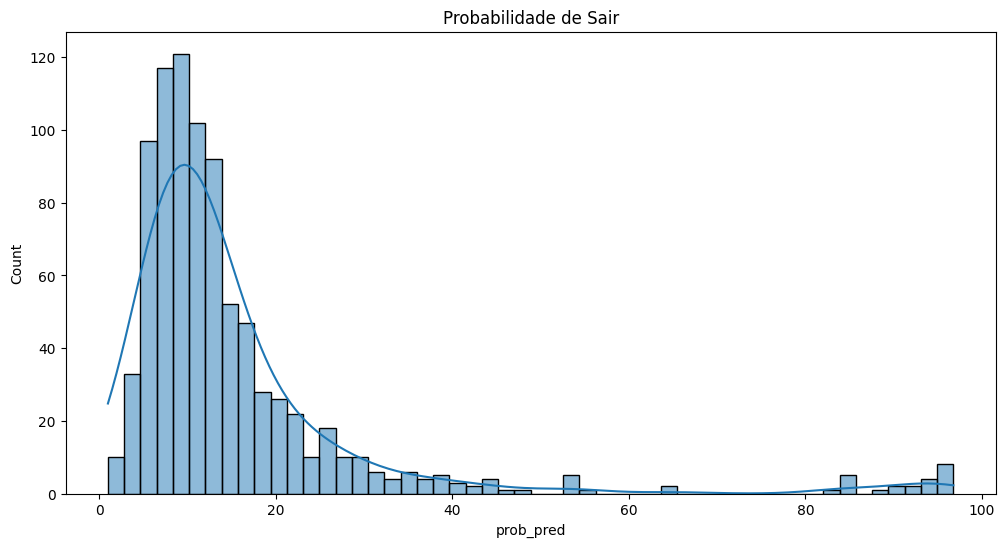

In [190]:
# Prever com o modelo
prob_pred_2022 = model.predict(X_2022)

# Ajustar para 0 ou 1
y_pred_2022 = np.round(prob_pred_2022)

# Adicionar as previsões ao dataframe
df_2022['saiu_pred'] = y_pred_2022.astype(int)

# Adicionar as probabilidades
df_2022['prob_pred'] = prob_pred_2022

# Plotar a probabilidade de sair
plt.figure(figsize=(12, 6))
sns.histplot(df_2022['prob_pred']*100, kde=True)
plt.title('Probabilidade de Sair')
plt.show()

In [191]:
# Saíram x Ficaram
df_2022.saiu_pred.value_counts()

saiu_pred
0    831
1     31
Name: count, dtype: int64

In [192]:
# Taxa de evasão para 2022
df_2022.saiu_pred.value_counts(normalize=True)*100

saiu_pred
0    96.403712
1     3.596288
Name: proportion, dtype: float64

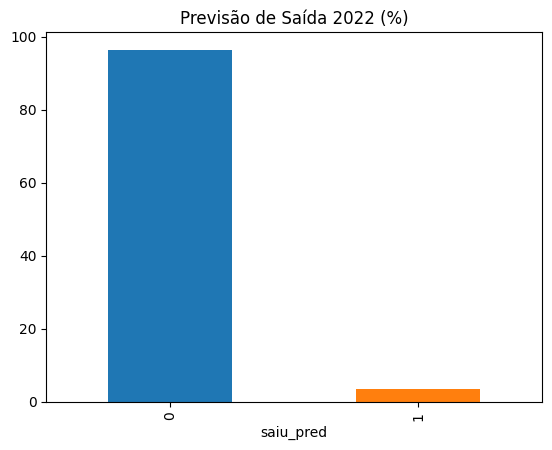

In [188]:
# Plot
(df_2022.saiu_pred.value_counts(normalize=True)*100).plot(kind='bar', color=['tab:blue', 'tab:orange'], title='Previsão de Saída 2022 (%)');

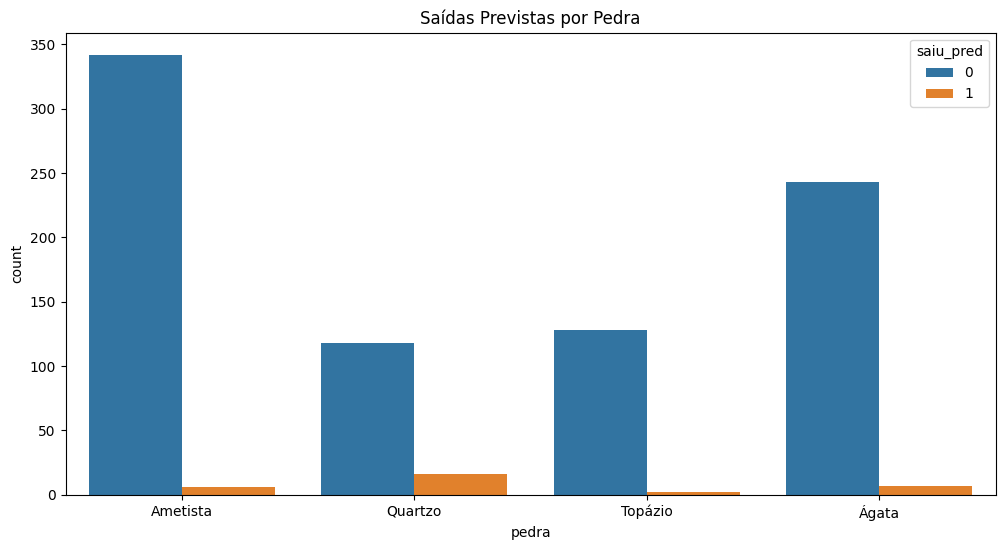

In [137]:
# Alunos que saíram
df_2022[df_2022['saiu_pred'] == 1]

# Plotar quantos saíram por pedra
plt.figure(figsize=(12, 6))
sns.countplot(data=df_2022, x='pedra', hue='saiu_pred')
plt.title('Saídas Previstas por Pedra')
plt.show()